In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

----
# Read in Data

In [3]:
df_raw = pd.read_csv('/Users/vinh/FS/thesis/data/raw/loan_status_2007_2020q3.gzip')
df_raw = df_raw.drop(columns = ['Unnamed: 0'], axis = 1)

data_dict = pd.read_excel('/Users/vinh/FS/thesis/data/raw/data_dictionary.xlsx', nrows = 152)               

/var/folders/l4/5vxm_0lj2qb6s9k_56jbryjr0000gn/T/ipykernel_92386/3276201340.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/Users/vinh/FS/thesis/data/raw/loan_status_2007_2020q3.gzip')


In [4]:
df_raw['loan_status'].value_counts(normalize = True)

Fully Paid                                             0.511976
Current                                                0.352425
Charged Off                                            0.123927
Late (31-120 days)                                     0.005522
In Grace Period                                        0.003428
Late (16-30 days)                                      0.000929
Issued                                                 0.000705
Does not meet the credit policy. Status:Fully Paid     0.000680
Does not meet the credit policy. Status:Charged Off    0.000260
Default                                                0.000148
Name: loan_status, dtype: float64

In [5]:
df_historical = df_raw.loc[df_raw['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
df_historical.loc[df_historical['loan_status'] == 'Default', 'loan_status'] = 'Charged Off'

In [6]:
df_historical['loan_status'].value_counts(normalize = True)

Fully Paid     0.804929
Charged Off    0.195071
Name: loan_status, dtype: float64

----
# Feature Selection

#### ---- Identify and remove features whose columns are missing a certain percentage of data. ----

In [10]:
def na_values_df(df):
    '''
    Function which creates a table describing NA values.

    Arguments:
        df: pd.DataFrame
            Dataframe which you want to describe NA values for.

    Returns:
        Dataframe containing 3 columns which describes NA values in given df.
    '''
    na_val_count = df.isnull().sum()
    na_val_percent = df.isnull().sum() / len(df)
    na_val_type = df.dtypes

    na_val_df = pd.concat([na_val_count, na_val_percent, na_val_type], axis = 1)
    na_val_df = na_val_df.rename(columns = {0: 'na_value_count',
                                            1: 'na_value_percent',
                                            2: 'na_value_type'
    })
    na_val_df['na_value_percent'] = round(na_val_df['na_value_percent'], 5)
    na_val_df = na_val_df.sort_values(by = 'na_value_percent', ascending = False)
    
    return na_val_df

In [11]:
df_historical_na = na_values_df(df_historical)

In [12]:
df_historical_na.head()

,na_value_count,na_value_percent,na_value_type
next_pymnt_d,1860331,0.99977,object
hardship_loan_status,1848068,0.99318,object
payment_plan_start_date,1848057,0.99317,object
hardship_type,1848057,0.99317,object
hardship_reason,1848056,0.99317,object


#### ---- Drop columns which have more than 45% of missing data. ----
We choose 0.45 as the cutoff since there is a drastic difference between missing data amongst the features.
The column `mths_since_recent_inq` is missing ~0.12441. The next column missing the most amount of data is `max_bal_bc` which spikes up to ~0.45489.

We go from 141 features to 92 after removing missing data.

In [13]:
na_cols_to_drop = df_historical_na.loc[df_historical_na['na_value_percent'] > 0.45].index.to_list()
df_historical = df_historical.drop(columns = na_cols_to_drop)

#### ---- Removing future data ----
There are some columns which provide information on a loan after it has gone into default. Using these columns in our model would be cheating because we don't want to use future data to predict default. Ideally, we would like to only use features which are known to an investor at the time of a loan's origination.

In [14]:
# `last_pymnt_d` may be a useful feature for a survival model
# `total_acc` may not be a cheat feature, remove anyways just to be safe
future_features = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                   'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt',
                   'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high',
                   'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
                   'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd',
                   'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
                   'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                   'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'out_prncp', 'out_prncp_inv',
                   'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens',
                   'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
                   'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
                   'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 'hardship_flag', 'debt_settlement_flag',
                   'url']
df_historical = df_historical.drop(columns = future_features)

After dropping the `future features`, we significantly reduce the amount of features we have from 92 to 31.

----
# Feature Cleaning

In [15]:
df_historical_clean = df_historical.copy()

In [16]:
# Convert `issue_d` to datetime
df_historical_clean['issue_d'] = pd.to_datetime(df_historical_clean['issue_d'])

# Convert `term` into int
df_historical_clean['term'] = df_historical_clean['term'].str.replace(' months', '').astype(int)

# Convert `int_rate` from string to float
df_historical_clean['int_rate'] = df_historical_clean['int_rate'].str.rstrip('%').astype(float) / 100

# Take only year from `earliest_cr_line`
df_historical_clean['earliest_cr_line'] = df_historical_clean['earliest_cr_line'].apply(lambda s: int(s[-4:]))

# Convert `emp_length` from string to int
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0,
}
df_historical_clean['emp_length'] = df_historical_clean['emp_length'].map(emp_length_mapping)

# Convert `revol_util` from string to float
df_historical_clean['revol_util'] = df_historical_clean['revol_util'].str.rstrip('%').astype(float) / 100

In [17]:
# Drop further features
drop = ['emp_title', # Categorical - 456737 unique values, too many to one hot encode
        'title', # Categorical - 61686 unique values, too many to one hot encode
        'zip_code', # Numerical - 950 unique values, use state instead of zip code
        'policy_code', # Numerical - Only has 1 unique value
        'fico_range_high' # Numerical - Max difference between `fico_range_low` & `fico_range_high` is 5, thus we only include `fico_range_low`
        ]

# Reorder columns: identifier columns not used for modeling and target feature `loan_status`
reorder = ['id', 'issue_d', 'grade', 'sub_grade', 'loan_status']

df_historical_clean = df_historical_clean.drop(columns = drop)
df_historical_clean = df_historical_clean[reorder + [col for col in df_historical_clean.columns if col not in reorder]]

----
# Remove Certain Years

In [28]:
df_historical_clean['year'] = pd.to_datetime(df_historical_clean['issue_d']).dt.year
loan_counts = df_historical_clean.groupby('year').size()

In [32]:
df_historical_clean['year'].value_counts(normalize = True)

2016    0.216634
2015    0.216490
2017    0.168946
2014    0.126625
2018    0.105966
2013    0.072451
2019    0.040524
2012    0.028680
2011    0.011673
2010    0.006200
2009    0.002534
2020    0.002303
2008    0.000839
2007    0.000135
Name: year, dtype: float64

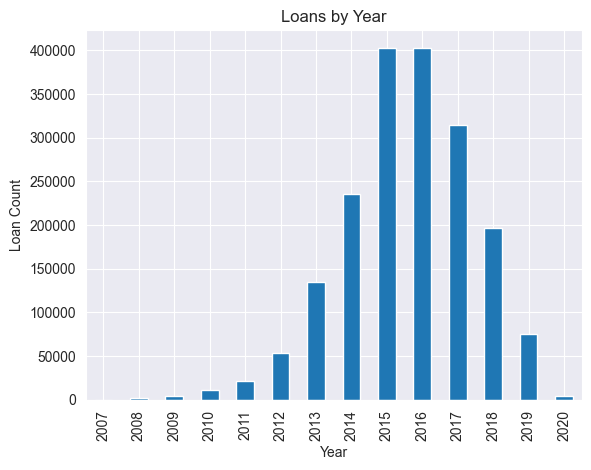

In [33]:
loan_counts.plot(kind = 'bar')
plt.title('Loans by Year')
plt.xlabel('Year')
plt.ylabel('Loan Count')
plt.show()

In [36]:
df_historical_clean = df_historical_clean.loc[(df_historical_clean['year'] >= 2013) & (df_historical_clean['year'] <= 2019)]

In [41]:
df_historical_clean.shape

(1763325, 27)

In [42]:
df_historical_clean.to_csv('/Users/vinh/FS/thesis/data/df_historical_clean.csv', index = False)

----
# Data Visualization

Visualize the remaining features to determine if further feature selection or feature engineering is necessary.

#### ---- Interactive Loan Map by State ----

In [43]:
loans_by_state = df_historical_clean.groupby(['addr_state'], as_index = False).size()

fig = go.Figure(
    data = go.Choropleth(
        locations = list(loans_by_state['addr_state'].values),
        z = list(loans_by_state['size'].values),
        locationmode = 'USA-states',
        colorscale = 'Blues',
        colorbar = dict(
            x = 0.75,
            y = 0.5,  
            len = 1,  
            thickness = 20,  
            titleside = 'right'
        )
))

fig.update_layout(
    title_text = 'Loans Given per State',
    title_x = 0.5,  
    title_y = 0.95,
    geo_scope = 'usa',
    margin = dict(l = 0, r = 0, t = 30, b = 0)
)


#### ---- Correlation Matrix - Numerical Features ----

In [44]:
df_historical_clean.head()

,id,issue_d,grade,sub_grade,loan_status,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year
42536,10129454,2013-12-01,B,B2,Fully Paid,12000.0,36,0.1099,392.81,4.0,RENT,60000.0,Not Verified,debt_consolidation,NC,4.62,2009,720.0,15.0,0.0,7137.0,0.240,f,Individual,0.0,0.0,2013
42537,10149488,2013-12-01,B,B2,Fully Paid,4800.0,36,0.1099,157.13,2.0,MORTGAGE,39600.0,Source Verified,home_improvement,TX,2.49,1995,755.0,3.0,0.0,4136.0,0.161,w,Individual,0.0,0.0,2013
42538,10149342,2013-12-01,B,B2,Fully Paid,27050.0,36,0.1099,885.46,10.0,OWN,55000.0,Verified,debt_consolidation,MI,22.87,1986,730.0,14.0,0.0,36638.0,0.612,w,Individual,4.0,0.0,2013
42539,10148122,2013-12-01,A,A3,Fully Paid,12000.0,36,0.0762,373.94,3.0,MORTGAGE,96500.0,Not Verified,debt_consolidation,TX,12.61,2003,705.0,17.0,0.0,13248.0,0.557,f,Individual,1.0,0.0,2013
42540,10129477,2013-12-01,B,B4,Fully Paid,14000.0,36,0.1285,470.71,4.0,RENT,88000.0,Not Verified,debt_consolidation,NC,10.02,1988,670.0,6.0,1.0,3686.0,0.819,f,Individual,0.0,1.0,2013


In [45]:
corr = df_historical_clean[['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
                            'annual_inc', 'dti', 'earliest_cr_line', 'fico_range_low', 'open_acc',
                            'pub_rec', 'revol_bal', 'revol_util', 'mort_acc', 'pub_rec_bankruptcies']].corr()

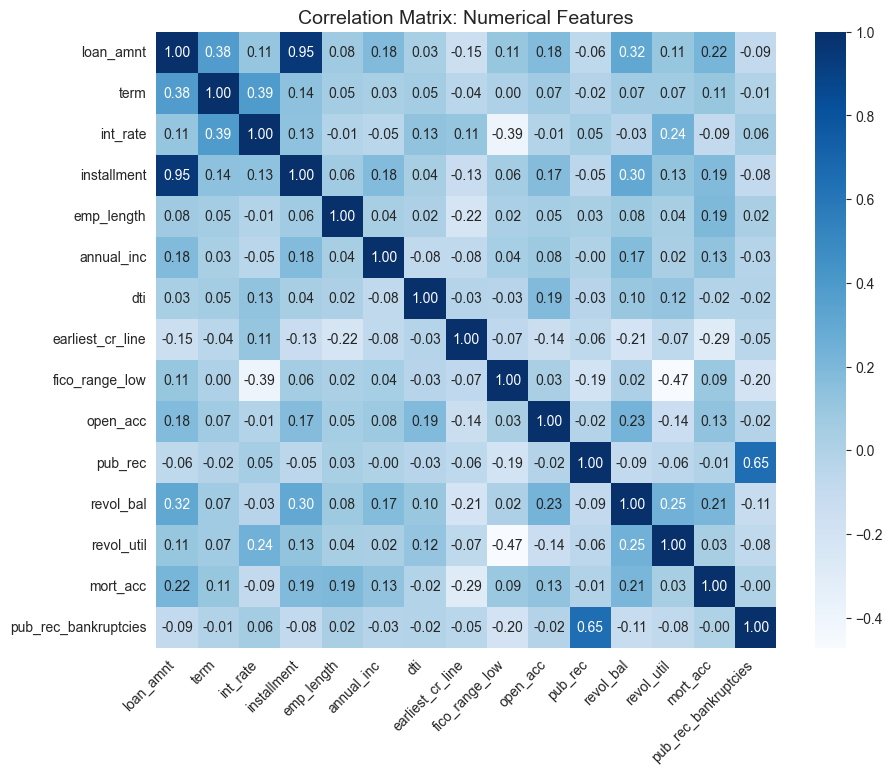

In [46]:
corr = df_historical_clean[['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
                            'annual_inc', 'dti', 'earliest_cr_line', 'fico_range_low', 'open_acc',
                            'pub_rec', 'revol_bal', 'revol_util', 'mort_acc', 'pub_rec_bankruptcies']].corr()
plt.figure(figsize = (10, 8))
heatmap = sns.heatmap(corr, annot = True, cmap = 'Blues', fmt = '.2f')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha = 'right', fontsize = 10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize = 10)
plt.title('Correlation Matrix: Numerical Features', fontsize = 14)
plt.show()

#### ---- Interest Rates by Fico Bin ----

In [47]:
df_historical_clean['fico_range_low'].describe()

count    1.763325e+06
mean     6.971331e+02
std      3.250184e+01
min      6.600000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.150000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64

In [48]:
fico_bins = [650, 700, 750, 800, 850]
df_historical_clean['fico_bin'] = pd.cut(df_historical_clean['fico_range_low'], fico_bins)
int_fico = df_historical_clean[['issue_d', 'int_rate', 'fico_range_low', 'fico_bin']]
int_fico['issue_d'] = pd.to_datetime(int_fico['issue_d']).dt.year
int_fico = int_fico.dropna()

/var/folders/l4/5vxm_0lj2qb6s9k_56jbryjr0000gn/T/ipykernel_92386/300328975.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



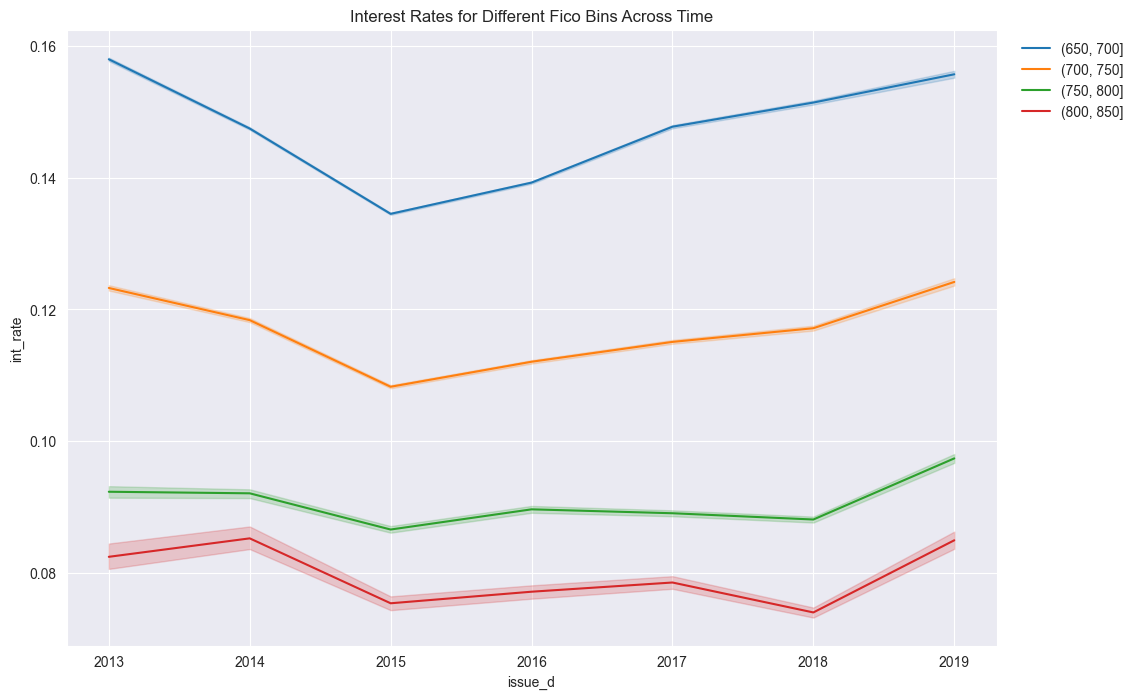

In [57]:
plt.figure(figsize = (12, 8))
sns.lineplot(data = int_fico, x = 'issue_d', y = 'int_rate', hue = 'fico_bin')
plt.title('Interest Rates for Different Fico Bins Across Time')
legend = plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), frameon = False)
plt.show()